<center><h1>Hands on Machine Learning with Scikit-Learn Project</h1></center>

### Group Members:

- Chakir EL ARRAG

- Fabio ALVES

- Manda Andriamaromanana

# Introduction

Our project aims to build a predictive model for the price of football players.
Since a price is an integer, without an obvious classification, we identify our problem as a regression task.

To achieve this regression task, we have 3 datasets, Player statistics, Player price and club statistics, club ranking, that we will use to predict the price of players.
Something we need to keep in mind is that we only have clubs and stats. However, others factors like the hype around a player or the attitude towards his teammates/dramas are not easy parameters to quantify, we can't calculate them but it has some impact on the price. This factor and prices that has big ranges (hundreds of millions), make it challenging to reach a perfect prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly


from os import listdir, environ
from os.path import isfile, join

from rapidfuzz import process

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from scipy.stats import t

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
%config InlineBackend.figure_format="retina"

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

# Dataset Creation

In [3]:
datasets = {}

path = "data/"
for f in listdir(path):
    if isfile(join(path, f)):
        datasets[f.replace(".csv", "")] = pd.read_csv(join(path, f))

print(datasets.keys())

dict_keys(['game_lineups', 'stats', 'Soccer_Football Clubs Ranking', 'players', 'club_games', 'clubs'])


We removed some datasets from the kaggle dataset. Since some of them are redundant or useless, as such, we have the "player_valuations" with the price of the player, something we can get from players.csv. So, we don't need to keep extra datasets.
We only modify/delete datasets in the transfertmarket dataset, we only keep players, game_lineups,clubs and club_games from it.

In [4]:
# Clear columns
clear_columns = {
    "players": {
        "first_name",
        "last_name",
        "player_code",
        "city_of_birth",
        "country_of_citizenship",
        "image_url",
        "url"
    },

    "stats": {
        "Rk", "Born", 
    }
}

# Clear too old data, we keep 2023 ones.
# The issue is that, we have valuations for each year. Something we don't want.

# Some names are in double in stats.csv, keep the newer


We want to merge "Players.csv" and "Stats.csv" into 1 dataset.

About the other datasets:
- We can get the win ratio in club_games
- How many time the player was a team captain and if he was in the starting team. 

In [5]:
lups = datasets["game_lineups"]
all_players = lups['player_id'].unique()

# captains
team_captain_games = lups[lups['team_captain'] == 1]
captain_counts = team_captain_games['player_id'].value_counts()
captain_counts = captain_counts.reindex(all_players, fill_value=0)

# starting
starting_lineups = lups[lups['type'] == "starting_lineup"]
starting_counts = starting_lineups['player_id'].value_counts()
starting_counts = starting_counts.reindex(all_players, fill_value=0)

# substitutes
substitutes = lups[lups['type'] == "substitutes"]
substitutes_counts = substitutes['player_id'].value_counts()
substitutes_counts = substitutes_counts.reindex(all_players, fill_value=0)

# Rename
substitutes_counts.columns = ['player_id', 'substitutes_number']
starting_counts.columns = ['player_id', 'starting_lineup_number']
captain_counts.columns = ['player_id', 'captain_number']

starting_counts = starting_counts.reset_index()
substitutes_counts = substitutes_counts.reset_index()
captain_counts = captain_counts.reset_index()

starting_counts = starting_counts.rename(columns={"count": "starting_count"})
substitutes_counts = substitutes_counts.rename(columns={"count": "substitutes_counts"})
captain_counts = captain_counts.rename(columns={"count": "captain_counts"})

# Merge the clean_dataset with counts DataFrames
_datasetCleaning = pd.merge(datasets["stats"], datasets["players"], on="name")
_datasetCleaning = pd.merge(_datasetCleaning, substitutes_counts, on="player_id", how="left")
_datasetCleaning = pd.merge(_datasetCleaning, starting_counts, on="player_id", how="left")
_datasetCleaning = pd.merge(_datasetCleaning, captain_counts, on="player_id", how="left")

In [6]:
_datasetCleaning.head()

,Rk,name,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,highest_market_value_in_eur,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,substitutes_counts,starting_count,captain_counts
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,30000000.0,2024-06-30 00:00:00,Wasserman,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/brenden-aarons...,L1,1.FC Union Berlin,12.0,5.0,0.0
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,2500000.0,2024-06-30 00:00:00,PSC,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/yunis-abdelham...,FR1,Stade Reims,0.0,14.0,14.0
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,2500000.0,2026-06-30 00:00:00,CNS,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/himad-abdelli/...,FR1,Angers SCO,NaN,NaN,NaN
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,18000000.0,2028-06-30 00:00:00,BLACKSKILL,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/salis-abdul-sa...,FR1,RC Lens,3.0,16.0,0.0
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,3000000.0,2026-06-30 00:00:00,N.Agency,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/laurent-aberge...,FR1,FC Lorient,0.0,14.0,14.0


In [7]:
print(_datasetCleaning.shape)

(1933, 149)


...

### Converting squad column into club ranking

Since the squad column is a categorical value with many possible outcomes, performing one-hot encoding on it would produce a big amount of columns (one for each team).

We know there should be a correlation between the club a player belongs to and a player's market value. Since good teams usually have good players, so more valuable ones. Therefore, we would like to keep some information about the team. 

In order to solve this problem, we use another dataset in which we have several football teams and their latest rankings, and we try to replace the club names with their rankings.

The first problem we encounter is that the clubs in our original dataset might be refered to with slightly different names than in the new dataset we're trying to use, since we got it from a different source, for example, 'Machester United' could be referred to as 'Man United'.

To resolve this, we use fuzzy matching to find, for each player’s club, the closest matching club name in the rankings dataset. Once the matches are established, we replace the club names in the original dataset with their corresponding rankings. This method works because the club names in both datasets are very similar and differ only by minor variations, such as spelling or abbreviations.

First, we notice that all the players we have in the original dataset play in the top five leagues, therefore we restrict the rankings dataset to teams from five countries (England, Spain, Germany, Italy and France). This is especially useful because some teams have the same name. For example, 'Real Sociedad' is both present in Spain and Uruguay. But we make sure that there are no teams with the same name from the rankings dataset in these five countries. This way we make sure the matching is done correctly.

In [8]:
# Players outside of the top 5 leagues in our dataset
s = 0
top5_leagues = ['Premier League', 'La Liga', 'Ligue 1', 'Bundesliga', 'Serie A']
indexes = []
n_rows = np.shape(_datasetCleaning)[0]
for i in range(n_rows):
    if _datasetCleaning.loc[i, 'Comp'] not in top5_leagues:
        s += 1
s

0

Since there are no players out of the top five leagues, we can proceed with restricting the rankings dataset on the five countries mentioned previously. 

In [9]:
rankings_df = pd.read_csv(path + 'Soccer_Football Clubs Ranking.csv', sep=';')

# We only keep teams in the big 5 leagues
rankings_df = rankings_df[rankings_df['country'].isin(['Germany', 'Spain', 'France', 'Italy', 'England'])]
rankings_df.head()

,ranking,club name,country,point score,1 year change,previous point scored,symbol change
0,88,1. FC Köln,Germany,1633,105,1545,+
1,74,1. FC Union Berlin,Germany,1655,5,1654,+
20,11,AC Milan,Italy,1850,21,1741,+
54,270,AFC Bournemouth,England,1512,7,1512,-
70,823,Ajaccio,France,1369,13,1369,-


We check for duplicates in the rankings dataset.

In [10]:
# Check for duplicate teams
duplicates = rankings_df['club name '][rankings_df['club name '].duplicated()]

if not duplicates.empty:
    print(f"There are {duplicates.nunique()} unique duplicate values and {duplicates.size} total duplicates in the column 'club name '.")
    print("Duplicate values and their counts:")
    print(duplicates.value_counts())
else:
    print(f"There are no duplicates in the column 'club name '.")

There are 6 unique duplicate values and 6 total duplicates in the column 'club name '.
Duplicate values and their counts:
club name 
Angers           1
Evian TG         1
GFC Ajaccio      1
Málaga           1
Middlesbrough    1
Nancy            1
Name: count, dtype: int64


In [11]:
duplicate_rows = rankings_df[rankings_df['club name '].duplicated(keep=False)]
duplicate_rows

,ranking,club name,country,point score,1 year change,previous point scored,symbol change
223,475,Angers,France,1440,121,1474,-
224,475,Angers,France,1440,121,1474,-
913,484,Evian TG,France,1439,2,1439,-
914,484,Evian TG,France,1439,2,1439,-
1165,485,GFC Ajaccio,France,1438,1,1438,-
1166,485,GFC Ajaccio,France,1438,1,1438,-
1628,451,Málaga,Spain,1446,1,1446,-
1629,451,Málaga,Spain,1446,1,1446,-
1691,465,Middlesbrough,England,1443,4,1443,-
1692,465,Middlesbrough,England,1443,4,1443,-


We notice that the rows don't refer to different teams, so we can delete the duplicates.

In [12]:
# Remove duplicate rows based on the column 'club name '
rankings_df = rankings_df.drop_duplicates(subset='club name ', keep='first')
duplicates = rankings_df['club name '][rankings_df['club name '].duplicated()]

if not duplicates.empty:
    print(f"There are {duplicates.nunique()} unique duplicate values and {duplicates.size} total duplicates in the column 'club name '.")
    print("Duplicate values and their counts:")
    print(duplicates.value_counts())
else:
    print(f"There are no duplicates in the column 'club name '.")

There are no duplicates in the column 'club name '.


Now, we can proceed with our matching:

In [13]:
# Create a dictionary of matches
club_list = rankings_df['club name '].tolist()
club_rankings = rankings_df.set_index('club name ')['ranking'].to_dict()

def get_best_match(club_name):
    match, score, _ = process.extractOne(club_name, club_list)
    if score >= 50: 
        return club_rankings[match]
    return None

# Apply the function to all rows
_datasetCleaning['Squad'] = _datasetCleaning['Squad'].apply(get_best_match)
_datasetCleaning.rename(columns={'Squad': 'Club Ranking'}, inplace=True)

The football clubs are replaced with their corresponding rankings. We can proceed with the data cleaning.

# Data Cleaning

## One-Hot encoding/String transform

In the original dataset, the foot side of players are plain text, with 2 possibles values, "Right" and "Left". Obviously, we can transform this attribute to 0 and 1.

In [14]:
_datasetCleaning["foot"] = [int(x == "right") for x in _datasetCleaning["foot"]]
_datasetCleaning = pd.concat([_datasetCleaning, pd.get_dummies(_datasetCleaning.sub_position)], axis=1)
_datasetCleaning = pd.concat([_datasetCleaning, pd.get_dummies(_datasetCleaning.Comp)], axis=1)

## Converting Columns to Numericals

We convert boolean columns to 0s and 1s.

In [15]:
bool_columns = _datasetCleaning.select_dtypes(include=['bool']).columns
for col in bool_columns:
    _datasetCleaning[col] = _datasetCleaning[col].astype(int)

print("Boolean columns converted to 0s and 1s.")

Boolean columns converted to 0s and 1s.


We drop non-numeric and useless columns that we don't need from our dataset.

For every drop, there the reason:
- "Rk", "name", "Nation", "first_name", "last_name", "player_code", "city_of_birth", "date_of_birth", "contract_expiration_date", "agent_name", "image_url", 
    'current_club_domestic_competition_id', "url": Not useful, there no specific values we can get from it.
- "country_of_birth", "country_of_citizenship", "current_club_name". These values may be useful, however, there is +100 unique values, with 2000 rows, this could bring issues with outliers making no sense. An example would be someone in a "unknown" country, models could think this is important for the price of the player and the prices of players coming from the same country is correlated.
- "sub_position", "position", "Comp". We one-hot encoded them, so we drop the string representation of these columns.
- Pos. We already have this value under another name.
- Born. We have the age of the player, something closer to 0 than born, and these 2 values gives roughly the same "idea".

In [16]:
# Identify non-numeric columns in the dataset
post_process_drops = [
    "Rk", "name", "Nation", "first_name", "last_name", "player_code", "city_of_birth", "date_of_birth", "contract_expiration_date", "agent_name", "image_url", "player_id", "current_club_id", "last_season",
    'current_club_domestic_competition_id', "url", # Not useful.
    "country_of_birth", "country_of_citizenship", # 102 unique values, we can't one-hot encode it else it would most likely make no sense for the regression.
    "sub_position", "position", "Comp", # one-hot encoding
    "current_club_name", # 198 unique values, same reason as the "country_of_birth"
    "Pos", # We already have a attribute about the position of the player.
    "Born" # The year in which a player is equivalent the age so we remove it. We already have it.
]

_datasetCleaning = _datasetCleaning.drop(post_process_drops, axis=1, errors='ignore')

We check if there are any non-numeric variables left. Since it would block most of models.

In [17]:
# Check for non-numeric columns
non_numeric_columns = _datasetCleaning.select_dtypes(exclude=['number'])
if not non_numeric_columns.empty:
    print("Non-numeric columns and their types:")
    for col in non_numeric_columns.columns:
        print(f"{col}: {non_numeric_columns[col].dtype}")
else:
    print("No non-numeric columns found.")

No non-numeric columns found.


## Null values

We remove columns having only null values (if they exist), and each row containing a null value.
Some columns are filled with null values, removing rows first would delete every values.
We delete na-filled columns first, and we delete null rows next.

In [18]:
# Cleaning null values
columnsSizePreNA = _datasetCleaning.shape[1]
_datasetCleaning.dropna(how='all', axis=1, inplace=True) # We remove useless columns
print("We removed " + str(columnsSizePreNA - _datasetCleaning.shape[1]) + " columns.")

columnsSizePreNA = _datasetCleaning.shape[0]
_datasetCleaning.dropna(how='any', axis=0, inplace=True) # We remove null values
print("We removed " + str(columnsSizePreNA - _datasetCleaning.shape[0]) + " rows.")

We removed 0 columns.
We removed 372 rows.


# Exploratory Data Analysis and Further Data Cleaning

## Correlations Between Independent Variables

We check for pairs of independent variables that are highly correlated.

In [19]:
correlations = _datasetCleaning.corr()
np.fill_diagonal(correlations.values, np.nan) 

high_corr_pairs = []
corr_dict = correlations.to_dict()
d_columns = list(corr_dict.keys())

for i in range(len(d_columns)):
    for j in range(i + 1, len(d_columns)):
        corr_value = corr_dict[d_columns[i]][d_columns[j]] 
        if abs(corr_value) > 0.9:
            high_corr_pairs.append({
                "Feature 1": d_columns[i],
                "Feature 2": d_columns[j],
                "Correlation": corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df.sort_values(by="Correlation", ascending=False, inplace=True)  # Sort by correlation
    print("Highly correlated feature pairs:")
    print(high_corr_df)
else:
    print("No highly correlated feature pairs found.")

Highly correlated feature pairs:
     Feature 1   Feature 2  Correlation
34      PasCrs         Crs     1.000000
13   PasTotAtt      PasAtt     1.000000
9    PasTotCmp      PasCmp     1.000000
38      TklWon        TklW     1.000000
40     Touches     TouLive     0.999996
4          Min         90s     0.999991
2       Starts         Min     0.991485
3       Starts         90s     0.991471
23   PasShoCmp   PasShoAtt     0.985336
24   PasMedCmp   PasMedAtt     0.981963
25      PasAtt     PasLive     0.976864
14   PasTotAtt     PasLive     0.976864
8    PasTotCmp     PasLive     0.974533
29     PasLive      PasCmp     0.974533
5    PasTotCmp   PasTotAtt     0.973655
7    PasTotCmp      PasAtt     0.973655
26      PasAtt      PasCmp     0.973655
15   PasTotAtt      PasCmp     0.973655
28      PasAtt     TouLive     0.968168
17   PasTotAtt     TouLive     0.968168
16   PasTotAtt     Touches     0.968156
27      PasAtt     Touches     0.968156
30     PasLive     Touches     0.957229
31     

We notice that some pairs of independent variables have very high correlation, so there is multicollinearity. Some of them reaching one in absolute value, which means some features might carry redundant information. For example 'Min' represents the number of minutes played by a player. and '90s' represents how many 90 minutes were played (matches), and the two are linked by the following relationship $\text{90s} = \frac{\text{Min}}{90}$. 

So by keeping the two variables we store some redudant information. This can negatively impact certain machine learning models, especially linear models or those sensitive to feature scaling and relationships (e.g., Logistic Regression, Linear Regression) where coefficients become unreliable due to the inability to distinguish the impact of correlated variables. 

Therefore, we proceed by removing some of the independent variable that have high correlations. We focus on the ones that have the most high correlations, for example 'PasTotAtt' has very high correlations with six other independent variables, so we remove it.

Based on the correlation values, we identify the following columns to remove: "Starts", "90s", "Rec", "PasTotCmp", "PasTotAtt", "PasTotDist", "PasShoCmp", "PasMedCmp", "PasAtt", "PasLive", "PasCrs", "TklW", "Touches".

In [20]:
post_process_drops = [
    "Starts", "90s", "Rec", "PasTotCmp", "PasTotAtt", "PasTotDist", "PasShoCmp", "PasMedCmp", "PasAtt", "PasLive", "PasCrs", "TklW", "Touches"
]

_datasetCleaning = _datasetCleaning.drop(post_process_drops, axis=1, errors='ignore')

## Correlations With the Target Variable and Data Visualisation

We compute the correlations with the target variable, and we check for the highest correlations in absolute value.

In [21]:
target = 'market_value_in_eur'
correlations = _datasetCleaning.corr()
corr_with_target = correlations[target].drop(target)
high_corr = corr_with_target[abs(corr_with_target) > 0.25].sort_values(ascending=False)


if not high_corr.empty:
    high_corr_df = high_corr.reset_index()
    high_corr_df.columns = ["Feature", "Correlation"]
    print("Features with high correlation to the target variable:")
    print(high_corr_df)
else:
    print("No features found with correlation > 0.25 to the target variable.")

Features with high correlation to the target variable:
                       Feature  Correlation
0  highest_market_value_in_eur     0.794484
1                        Goals     0.426172
2               starting_count     0.389394
3                          Min     0.316835
4                           MP     0.282413
5               Premier League     0.278049
6                 Club Ranking    -0.255054


- 'Club Ranking': The correlation is negative because higher club rankings (closer to 1, so better teams) are associated with more valuable players. However, this does not mean that every player belonging to a top team has a high market value. For example, substitutes are usually not as good as the players in the starting eleven. As a result, the negative correlation between club ranking and market value exists but is not very strong in absolute value.

- 'Min': The correlation is positive, as players with more minutes on the field are more likely to be skilled and stand out, leading to higher market value. However, this is not always the case. In lower-ranked teams, less valuable players often get more minutes due to a lack of better options. Additionally, some highly valuable players in top teams might spend more time on the bench, and injuries can also reduce minutes for valuable players. Therefore, while there is a positive correlation, it is not very high.

- 'Goals': There is a positive correlation, and it is one of the highest among features. Players who score the most goals usually have higher market values. However, this correlation may vary for players in smaller teams who get more minutes and score goals, their overall market value might still depend on other stats or skills and especially on the league they're playing in.

- 'highest_market_value_in_eur': High correlation with the target variable, this is due to the fact that many players might currently have their highest market value.

- 'starting_count': Third highest correlation with the target variable, this is mainly due to the fact that players that start more matches, tend to be the best in their teams and therefore more valuable.

- 'Premier League': There is a positive correlation. Over recent years, market values for players in the Premier League have tended to be higher compared to players in other leagues. This is due to factors like the Premier League’s intensity and competitiveness, the influence of the English press and PR, and the league’s financial capacity. Players with similar skills in other leagues might be evaluated differently because of these factors.

Next, we make scatterplots of some of the variables that are highly correlated with the dependent variable:

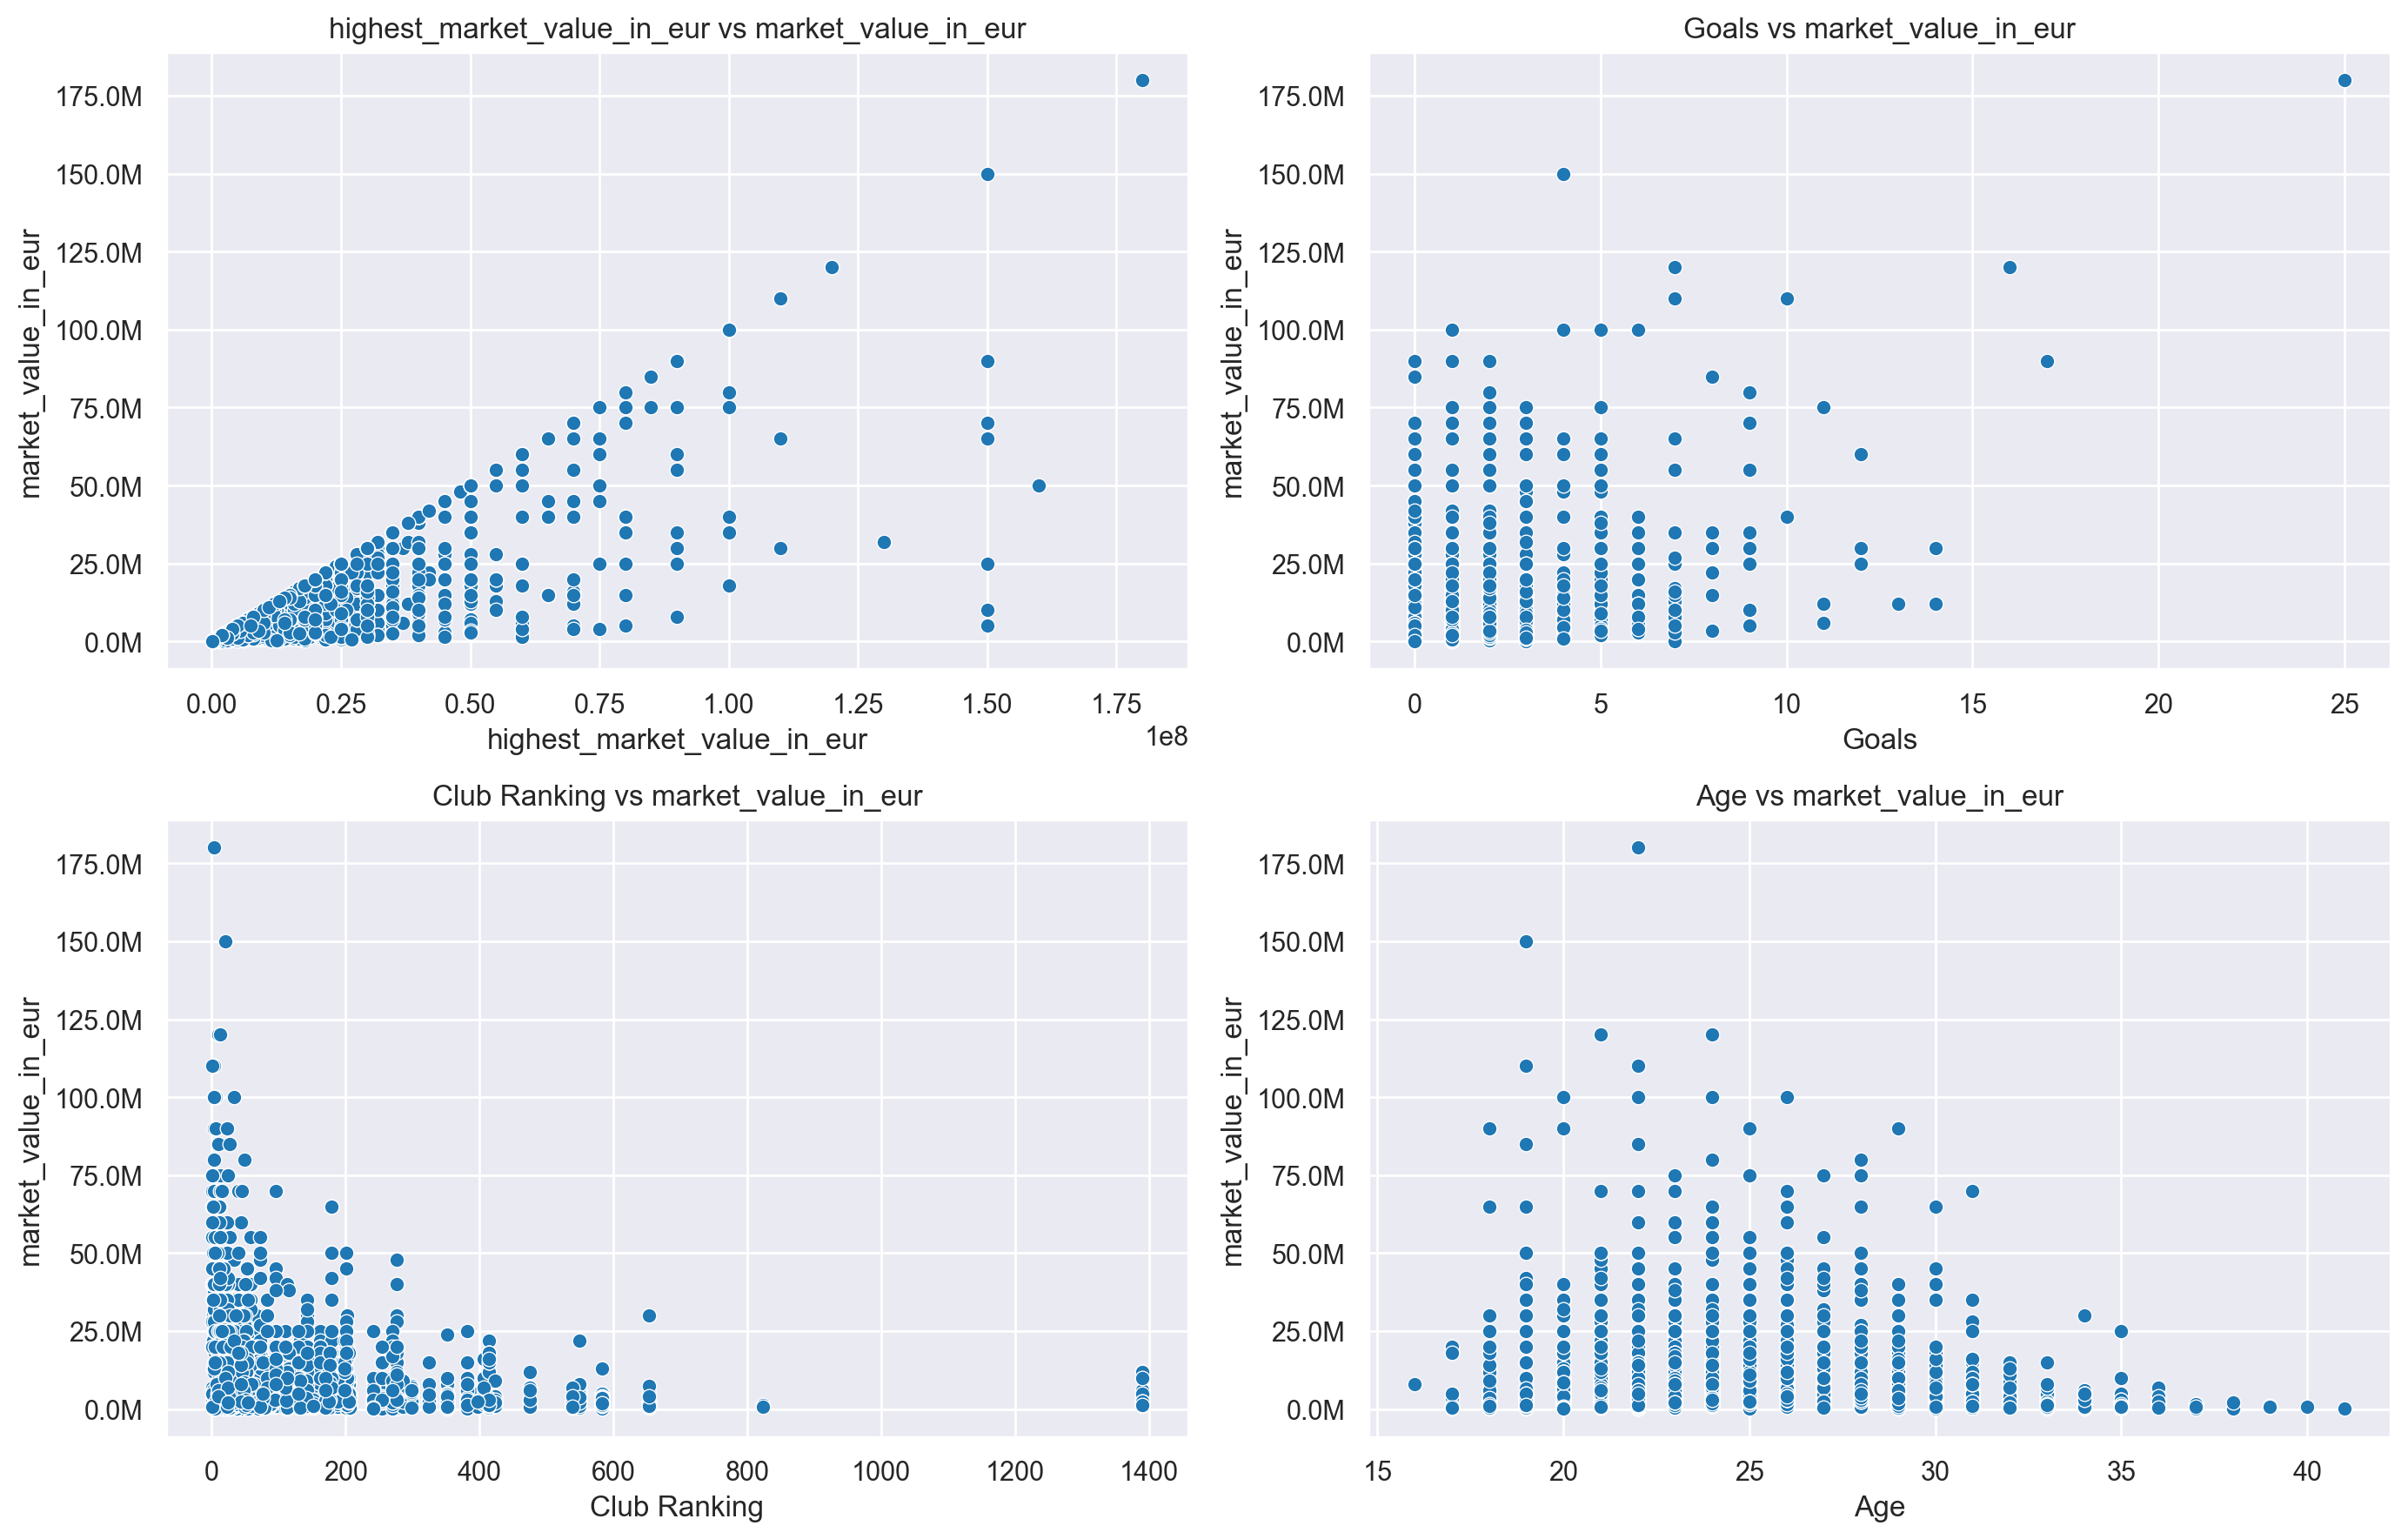

In [22]:
selected_variables = ['highest_market_value_in_eur', 'Goals', 'Club Ranking', 'Age']

def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M' 

plt.figure(figsize=(14, 9))

for i, var in enumerate(selected_variables):
    plt.subplot(2, 2, i + 1) 
    sns.scatterplot(_datasetCleaning, x=selected_variables[i], y=target)
    plt.title(f"{var} vs {target}")
    plt.xlabel(var)
    plt.ylabel(target)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.tight_layout()
plt.show()

- 'highest_market_value_in_eur' : We notice a linear relationship with the target variable. As we mentioned before, this is due to the fact that many players market value is historically their highest, and often a player's market value is not very far from its highest. Exceptions to this occur when a player is very old, or their performances have consistently declined over a long period.

- 'Goals': Most of the goal values are concentrated in the interval $[0, 5]$. Within this range, the market value is spread, indicating that scoring few goals does not always imply a specific market value. As the number of goals gets higher we tend to see higher market values.

- 'Club Ranking': As discussed earlier, we generally observe higher market values for players in top teams (those with lower ranking numbers). However, there is a high density of players with lower market values playing for teams ranked in the top 200. Additionally, we observe some outliers in teams ranked extremely low (below 1000). These outliers are removed from the analysis to avoid distortion of results.

- 'Age': The scatterplot displays a clear non linear pattern with a peak around a specific age range (likely in the early to mid 20s). This reflects players in their prime, when their physical abilities, experience, and skill sets are at their peak. Players aged below 23 generally have lower market values, with a few exceptions (likely exceptional talents or players with high potential). Young players are still developing their skills and gaining experience, which limits their immediate market value. Older players are perceived as having less long-term potential and reduced physical capabilities, leading to a sharp decline in market value. Some experienced top players may still retain relatively high market values, but they are very rare exceptions.

We also notice some two outliers in terms of market value, which are the two current most expensive players. We decide to remove them before feeding the data to our models so that the performance doesn't get affected.

In [23]:
_datasetCleaning = _datasetCleaning[_datasetCleaning['Club Ranking'] < 1000]
_datasetCleaning = _datasetCleaning[_datasetCleaning[target] < 125000000]

For 'Premier League', which is a categorical variable (binary), we plot the two boxplots showing the market value (dependent variables) for players in the Premier League and players in the other four leagues.

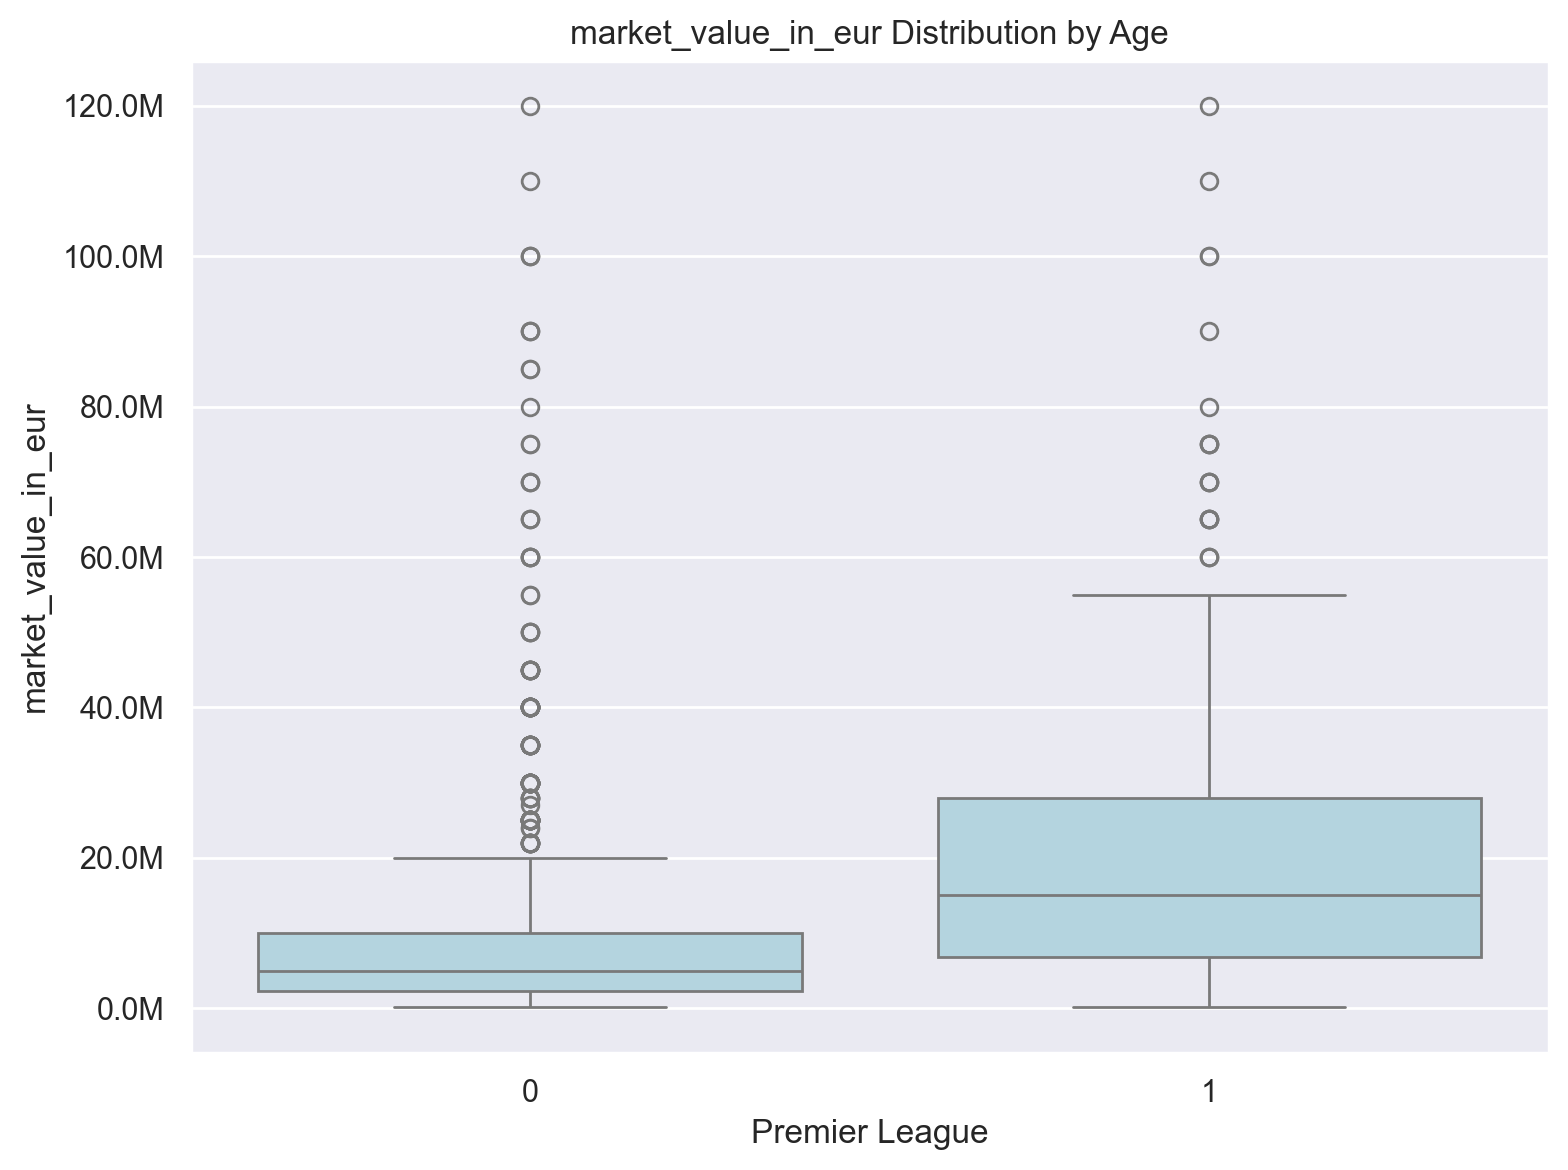

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=_datasetCleaning['Premier League'], y=_datasetCleaning[target], color='lightblue')
plt.title(f"{target} Distribution by Age")
plt.xlabel('Premier League')
plt.ylabel(target)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

We observe that the median and, in particular, the 75th percentile of market value are significantly higher for players in the Premier League. This supports our earlier argument that players in the Premier League tend to achieve higher market values on average.

## Feature transformation

By looking at the scatterplot of 'market_value_in_eur' vs 'Club Ranking', we notice a non linear relationship between the two variables.
We denote the dependent variable as $y$ (market value) and the independent variable as $x$ (‘Club Ranking’), the relationship between the two can be approximated as $y \propto \frac{1}{x}$, with the points being densly concentrated under the curve $y = \frac{1}{x}$. Furthermore, we notice that as the rankings approach 1 (top teams), the density of players with very high market values is not as high, and we still have a lot of players with low market value. Therefore, we can refine the approximation of the relationship and say that $y \propto \frac{1}{\sqrt[4]{x}}$, with the points densely concentrated under this curve.

Based on these findings, and in order to exploit this relationship, we apply a feature transformation to the variable $x$ (Club Ranking) by creating a new feature $f(x) = \frac{1}{\sqrt[4]{x}}$. This reciprocal fourth root feature mapping, is performed to capture the observed non-linear relationship between $x$ and the target variable $y$ (Market Value). The original variable $x$ is mapped to a new space where the relationship with $y$ becomes more linear and better aligns with the dense distribution of points under the curve $y = \frac{1}{\sqrt[4]{x}}$. This process is an example of feature mapping, which transforms features to enhance their relevance and improve the model’s ability to learn meaningful patterns. We call this new variable 'club_trans'.

In [25]:
_datasetCleaning['club_trans'] = 1/np.power(_datasetCleaning['Club Ranking'], (1/4))
_datasetCleaning.head()

,Club Ranking,Age,MP,Min,Goals,Shots,SoT,SoT%,G/Sh,G/SoT,...,Right Midfield,Right Winger,Right-Back,Second Striker,Bundesliga,La Liga,Ligue 1,Premier League,Serie A,club_trans
0,162,22,20,1596,1,1.53,0.28,18.5,0.04,0.20,...,0,0,0,0,0,0,0,1,0,0.280299
1,203,35,22,1980,0,0.86,0.05,5.3,0.00,0.00,...,0,0,0,0,0,0,1,0,0,0.264927
3,199,22,20,1799,1,0.60,0.15,25.0,0.08,0.33,...,0,0,0,0,0,0,1,0,0,0.266248
4,382,30,15,1165,0,0.31,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,1,0,0,0.226196
5,79,26,1,11,0,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0.335423


We show a scatterplot of the new variable vs market value.

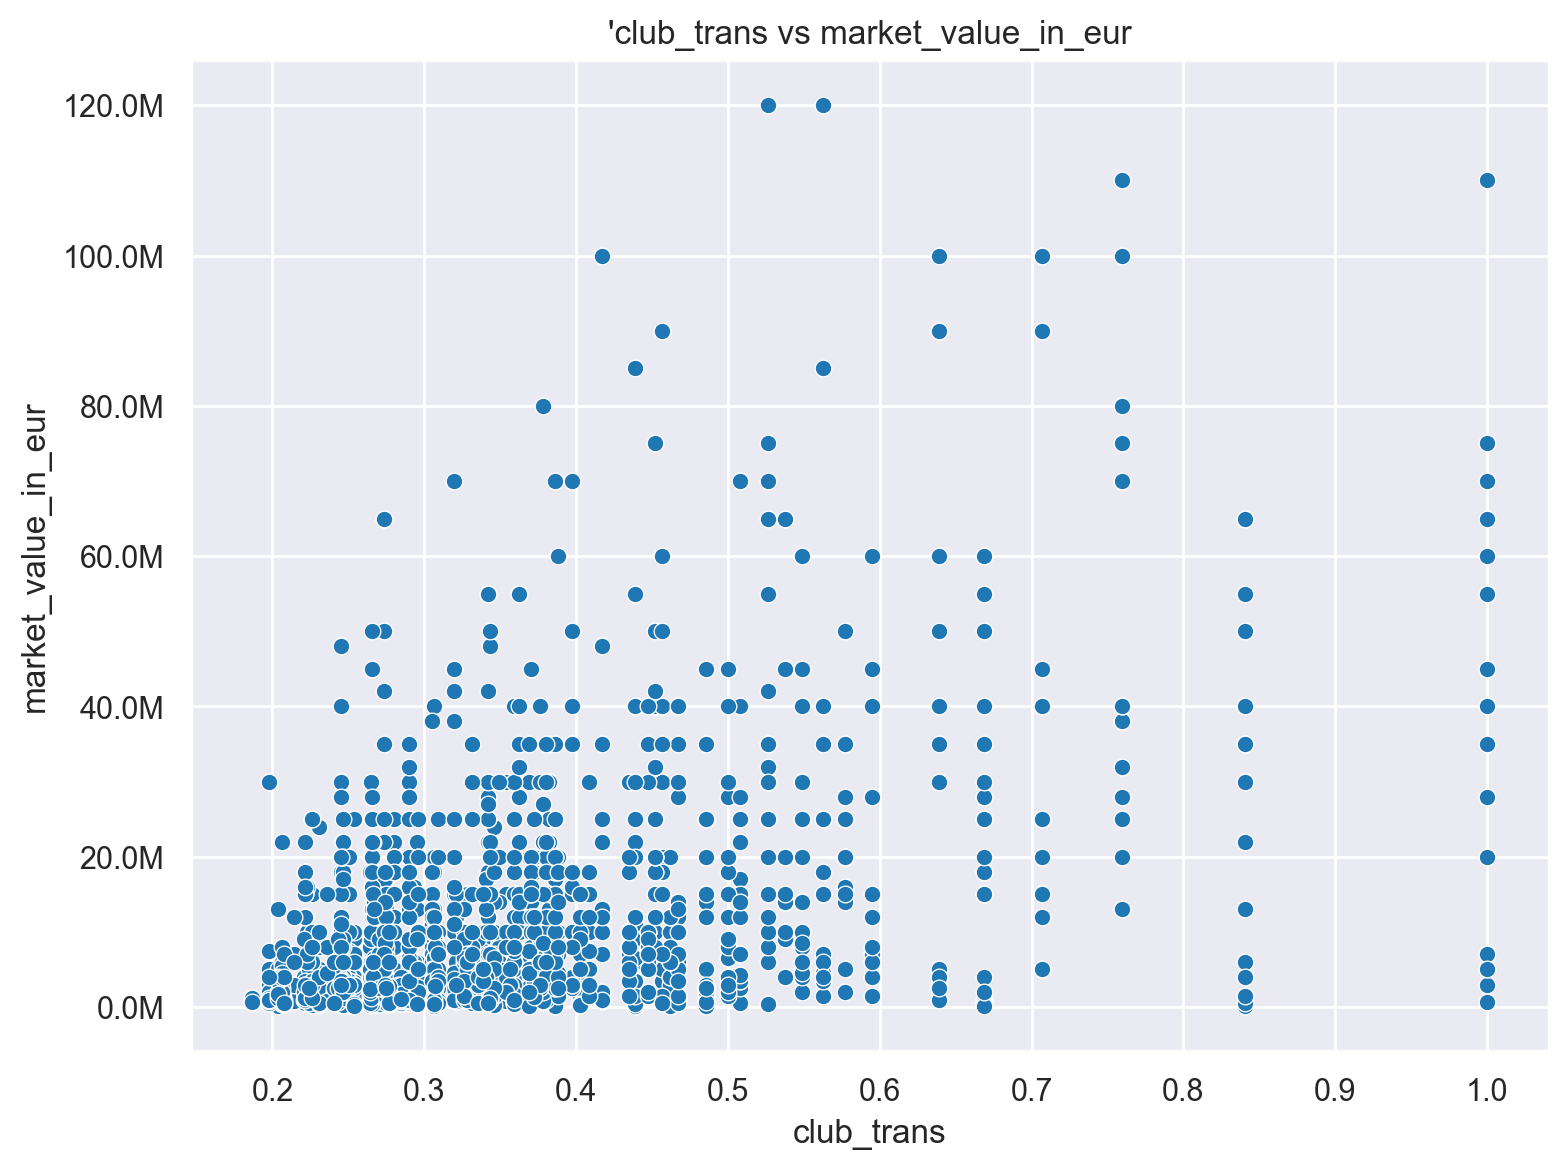

In [26]:
plt.figure(figsize=(8, 6)) 
sns.scatterplot(data=_datasetCleaning, x='club_trans', y=target)
plt.title(f"'club_trans vs {target}")
plt.xlabel('club_trans')
plt.ylabel(target)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

Correlation of the new feature with the target:

In [27]:
print(_datasetCleaning['club_trans'].corr(_datasetCleaning[target]))

0.46741339196502435


We observe that the relationship between the new variable and the target is more linear. Additionally, the correlation between the two is one of the highest, indicating that the transformation was effective in improving the relationship and capturing the underlying pattern.

In [28]:
_datasetCleaning.head()

,Club Ranking,Age,MP,Min,Goals,Shots,SoT,SoT%,G/Sh,G/SoT,...,Right Midfield,Right Winger,Right-Back,Second Striker,Bundesliga,La Liga,Ligue 1,Premier League,Serie A,club_trans
0,162,22,20,1596,1,1.53,0.28,18.5,0.04,0.20,...,0,0,0,0,0,0,0,1,0,0.280299
1,203,35,22,1980,0,0.86,0.05,5.3,0.00,0.00,...,0,0,0,0,0,0,1,0,0,0.264927
3,199,22,20,1799,1,0.60,0.15,25.0,0.08,0.33,...,0,0,0,0,0,0,1,0,0,0.266248
4,382,30,15,1165,0,0.31,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,1,0,0,0.226196
5,79,26,1,11,0,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0.335423


# Train-Test Split

We split the dataset in train and test, something classic. However, we choose to avoid using a valid set. The reason is the low number of entries (~1850).

In [29]:
X = _datasetCleaning.drop(target, axis=1)
Y = _datasetCleaning[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

# Model Selection

In this section, we make a pipeline that performs the scaling of our data, this is only using standard scaling. Then it optionally performs PCA and next trains the model.
We use cross validation on the number of components of the PCA, and the option whether to use PCA or not and on the parameters of our models to evaluate. We perform the selection based on the mean squared error metric. 
We evaluate seven models with different combination of parameters for the model and for the PCA and we choose the most performing one. These are the evaluated models and their parameters:

- Linear Regression: {"model__fit_intercept": [True, False]}

- Ridge Regression: {"model__alpha": [0.1, 1.0, 10.0]}

- Lasso Regression : {"model__alpha": [0.01, 0.1, 1.0]}

- ElasticNet: (ElasticNet(), {"model__alpha": [0.01, 0.1, 1.0], "model__l1_ratio": [0.3, 0.5, 0.7]}),

- Decision Tree: {"model__max_depth": [3, 5, 10], "model__min_samples_split": [2, 5, 10]}

- Random Forest: {"model__n_estimators": [50, 100, 200], "model__max_depth": [3, 5, 10]}

- Gradient Boosting: {"model__n_estimators": [50, 100, 200], "model__learning_rate": [0.01, 0.1, 0.2], "model__max_depth": [3, 5]}

For PCA, we check for the following numbers of components [None, 5, 10, 25, 50, 100].

We include none to include skipping PCA as an option, but setting 'n_components' = None still performs PCA. In order to solve this issue, we build our parameter list for PCA such that when the value is null it passes a FunctionTransformer, which is an object that tranforms the data according to a chosen function. To skip PCA we assign this object with the identity function as input, which leaves the data unchanged and therefore skips the PCA step. In the other cases (n_components not null), the parameter list gives the PCA object with the corresponding number of components.

In [30]:
models = {
    "Linear Regression": (LinearRegression(), {"model__fit_intercept": [True, False]}),
    "Ridge Regression": (Ridge(), {"model__alpha": [0.1, 1.0, 10.0]}),
    "Lasso Regression": (Lasso(), {"model__alpha": [0.01, 0.1, 1.0]}),
    "ElasticNet": (ElasticNet(), {"model__alpha": [0.01, 0.1, 1.0], "model__l1_ratio": [0.3, 0.5, 0.7]}),
    "Decision Tree": (DecisionTreeRegressor(), {"model__max_depth": [3, 5, 10], "model__min_samples_split": [2, 5, 10]}),
    "Random Forest": (RandomForestRegressor(random_state=42), {"model__n_estimators": [50, 100], "model__max_depth": [3, 5, 10]}),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1, 0.2], "model__max_depth": [3, 5]})
}

environ["PYTHONWARNINGS"] = "ignore"

# Dictionary to store results
results = {}

best_model_name = None
best_model = None
best_score = 0

for name, (model, params) in models.items():
    print(f"Training {name}...")
    
    # Create the pipeline with standard scaler, PCA (optional), and the model
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", model)
    ])
    
    # Add PCA-related hyperparameters to the grid search
    pca_options = [None, 5, 25, 50, 100]  # No PCA (None) and PCA options
    pca_param = {"pca": [PCA(n_components=n) if n else FunctionTransformer(lambda x: x) for n in pca_options]}  # Identity transformer for no PCA
    full_params = {**params, **pca_param}
    
    # Perform GridSearchCV
    grid = GridSearchCV(
        pipeline, 
        param_grid=full_params, 
        cv=5, 
        scoring={'MSE': 'neg_mean_squared_error', 'R2': 'r2'}, 
        refit='MSE',  
        n_jobs=-1,
    )
    grid.fit(X_train, y_train)

    best_model_current = grid.best_estimator_
    best_cv_mse = -grid.cv_results_['mean_test_MSE'][grid.best_index_] 
    best_cv_r2 = grid.cv_results_['mean_test_R2'][grid.best_index_]

    # Store results
    results[name] = {
        "Best Params": grid.best_params_,
        "Best CV Score (MSE)": best_cv_mse,
        "Best CV Score (R^2)": best_cv_r2,
        "Best Model": best_model_current
    }

    print(f"{name}")
    print(f"Best Params: {grid.best_params_}")
    print(f"Best CV Score (MSE): {best_cv_mse:.2f}")
    print(f"Best CV Score (R^2): {best_cv_r2:.4f}\n")

    if best_score < best_cv_r2:
        best_score = best_cv_r2
        best_model_name = name
        best_model = best_model_current

Training Linear Regression...
Linear Regression
Best Params: {'model__fit_intercept': True, 'pca': PCA(n_components=100)}
Best CV Score (MSE): 77343527269342.70
Best CV Score (R^2): 0.6797

Training Ridge Regression...
Ridge Regression
Best Params: {'model__alpha': 10.0, 'pca': PCA(n_components=100)}
Best CV Score (MSE): 76905145453609.53
Best CV Score (R^2): 0.6815

Training Lasso Regression...
Lasso Regression
Best Params: {'model__alpha': 1.0, 'pca': PCA(n_components=100)}
Best CV Score (MSE): 77362825697411.20
Best CV Score (R^2): 0.6796

Training ElasticNet...
ElasticNet
Best Params: {'model__alpha': 0.1, 'model__l1_ratio': 0.3, 'pca': FunctionTransformer(func=<function <lambda> at 0x13908b9c0>)}
Best CV Score (MSE): 75447106608008.00
Best CV Score (R^2): 0.6887

Training Decision Tree...
Decision Tree
Best Params: {'model__max_depth': 5, 'model__min_samples_split': 10, 'pca': FunctionTransformer(func=<function <lambda> at 0x13ead6ac0>)}
Best CV Score (MSE): 82605571937849.03
Best

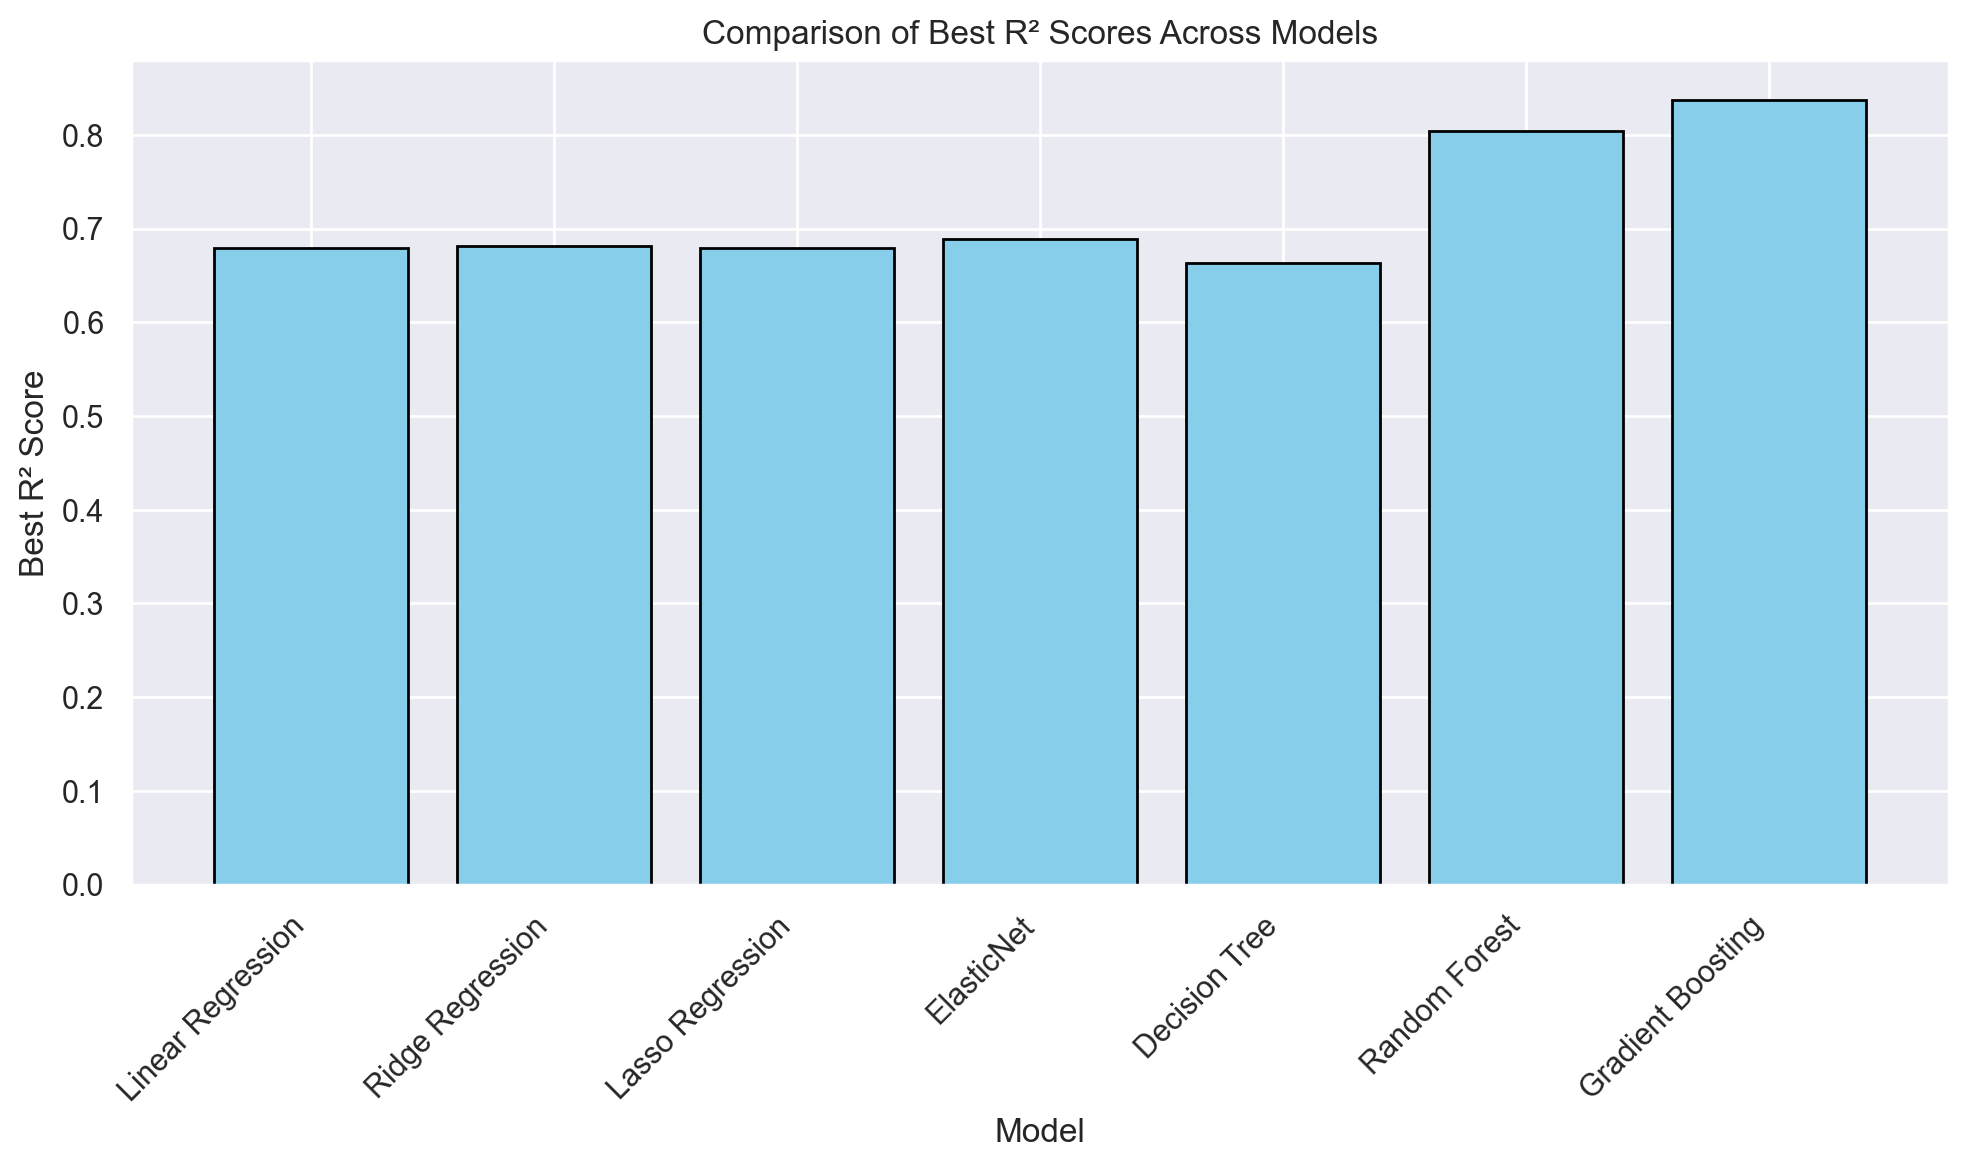

In [31]:
model_names = list(results.keys())
r2_scores = [results[name]["Best CV Score (R^2)"] for name in model_names]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores, color='skyblue', edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Best R² Score')
plt.title('Comparison of Best R² Scores Across Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The best performing model is Gradient Boosting, with the lowest mean square error with a substantial gap from other models, and with the highst R squared value.

We notice that the best performing pipeline does not use PCA. We list the best combination of parameters:

In [32]:
results[best_model_name]['Best Params']

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100,
 'pca': FunctionTransformer(func=<function <lambda> at 0x13eaf53a0>)}

# Prediction on the Test Set

We use the best model we got to predict the test set.

In [33]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 FunctionTransformer(func=<function <lambda> at 0x13eaf53a0>)),
                ('model', GradientBoostingRegressor(random_state=42))])

In [34]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test Score MSE: {mse:.0f}")
print(f"Test Score MAE: {mae:.0f}")
print(f"Test Score R^2: {r2:.4f}")

Test Score MSE: 36898005546138
Test Score MAE: 3600359
Test Score R^2: 0.8788


We notice that the performance of our model on the test set is almost the same as in the validation set, which means our model generalizes well on unseen data and doesn't overfit on the training set.

The Mean Absolute Error gives us an idea of the error made on average by our model in predicting the market value. This error is pretty low considering that the market value can get up to $200m for some players.

# Error Analysis

## Confidence Interval for the Mean Absolute Error

To give further information about our mean absolute error, which represents the average error on a prediction, we try to give a confidence interval.

We can notice that this metric is the mean of multiple observations of a random variable (the error).

In [35]:
print(np.shape(y_test)[0])

386


We have 386 instances of errors, assumed to be independent and identically distributed (the errors are derived from repeated predictions of the same model on comparable data, with no indication of systematic variation across instances), which is enough to use the Central Limit Theorem, which allows us to state that MAE tends to follow a normal distribution, $\text{MAE} \sim \mathcal{N}(\mu, \sigma^2)$, where $\mu$ and $\sigma^2$ are unknown parameters of the population.

Since our parameters are unknown, we use their following empirical estimates:

- For $\mu$ we use the sample mean $\bar{x} = \dfrac{1}{n} \sum_{i = 1}^{n} x_i$.

- For $\sigma^2$ we use the estimate $s^2 = \dfrac{1}{n-1}\sum_{i=1}^n (x_i - \bar x)^2$

Now we have to build the confidence interval. In order to do so we mention that the variable $\dfrac{\bar x-\mu}{\sqrt{\dfrac{s^2}n}}$ follows a Student's t-distribution with $n - 1$ degrees of freedom.

Therefore we can compute the confidence integral as follows: 
$CI = \bar{x} \pm t_{n-1, 1 - \frac{\alpha}{2}} \dfrac{s}{\sqrt{n}}$ for $(1 - \alpha)$% confidence.

Now everything is set, and we can compute the 95% confidence interval for our MAE.

In [36]:
def compute_confidence_interval(data, alpha=0.05):
    n = len(data)
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1) # ddof stands for degrees of freedom, we use it to divide by n-1 instead of n
    standard_error = sample_std / np.sqrt(n)
    
    t_critical = t.ppf(1 - alpha/2, df=n-1)
    margin_of_error = t_critical * standard_error
    
    # Confidence interval
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error
    
    return lower_bound, upper_bound

abs_errors = np.abs(y_test - y_pred)
lower, upper = compute_confidence_interval(abs_errors, 0.05)
print(f"Confidence Interval: [{lower:.0f}, {upper:.0f}]")

Confidence Interval: [3110123, 4090596]


We are 95% confident that the true mean absolute error (MAE) lies within the interval $[3.1\text{m}, 4.1\text{m}]$. This means that the average prediction error for the market value of football players is estimated to fall between €3.1 million and €4.1 million.

The confidence interval provides valuable information about the range of possible values for the true MAE, reflecting the uncertainty in the estimate based on the sample data.

Given that the market values of football players can go as high as €125 million, this range of error represents a small proportion of the highest market values. However, its acceptability should be evaluated relative to the distribution of market values across all players.

## Relative Errors

In the last section, we have provided information about the MAE, which is a metric giving an idea about the average error for each prediction, therefore the performance of our model on average.

Now, we would like to know where our model performs well and where it has difficulties. Our first intuition is that the model might struggle to predict points with market value very close to zero due to the high range for the dependent variable.

In order to inspect this, we compute the relative errors to each prediction. The relative error is a measure of the accuracy of a prediction, expressed as the ratio of the absolute error to the true value:

$$\text{Relative Error} = \frac{\text{Absolute Error}}{\text{True Market Value}}$$

It quantifies the error as a proportion of the true value, providing insight into the significance of the error relative to the size of what is being measured. In the context of predicting football players’ market values, relative error is particularly useful because the market values span a wide range, from very low to very high. While absolute errors might appear large for high-value players, their impact is smaller relative to the player’s true value. By examining relative error, we can assess the proportional accuracy of the model across different ranges of market values, ensuring fair evaluation and identifying where the model performs well or struggles.

Next, we compute the relative errors and we visualise them.

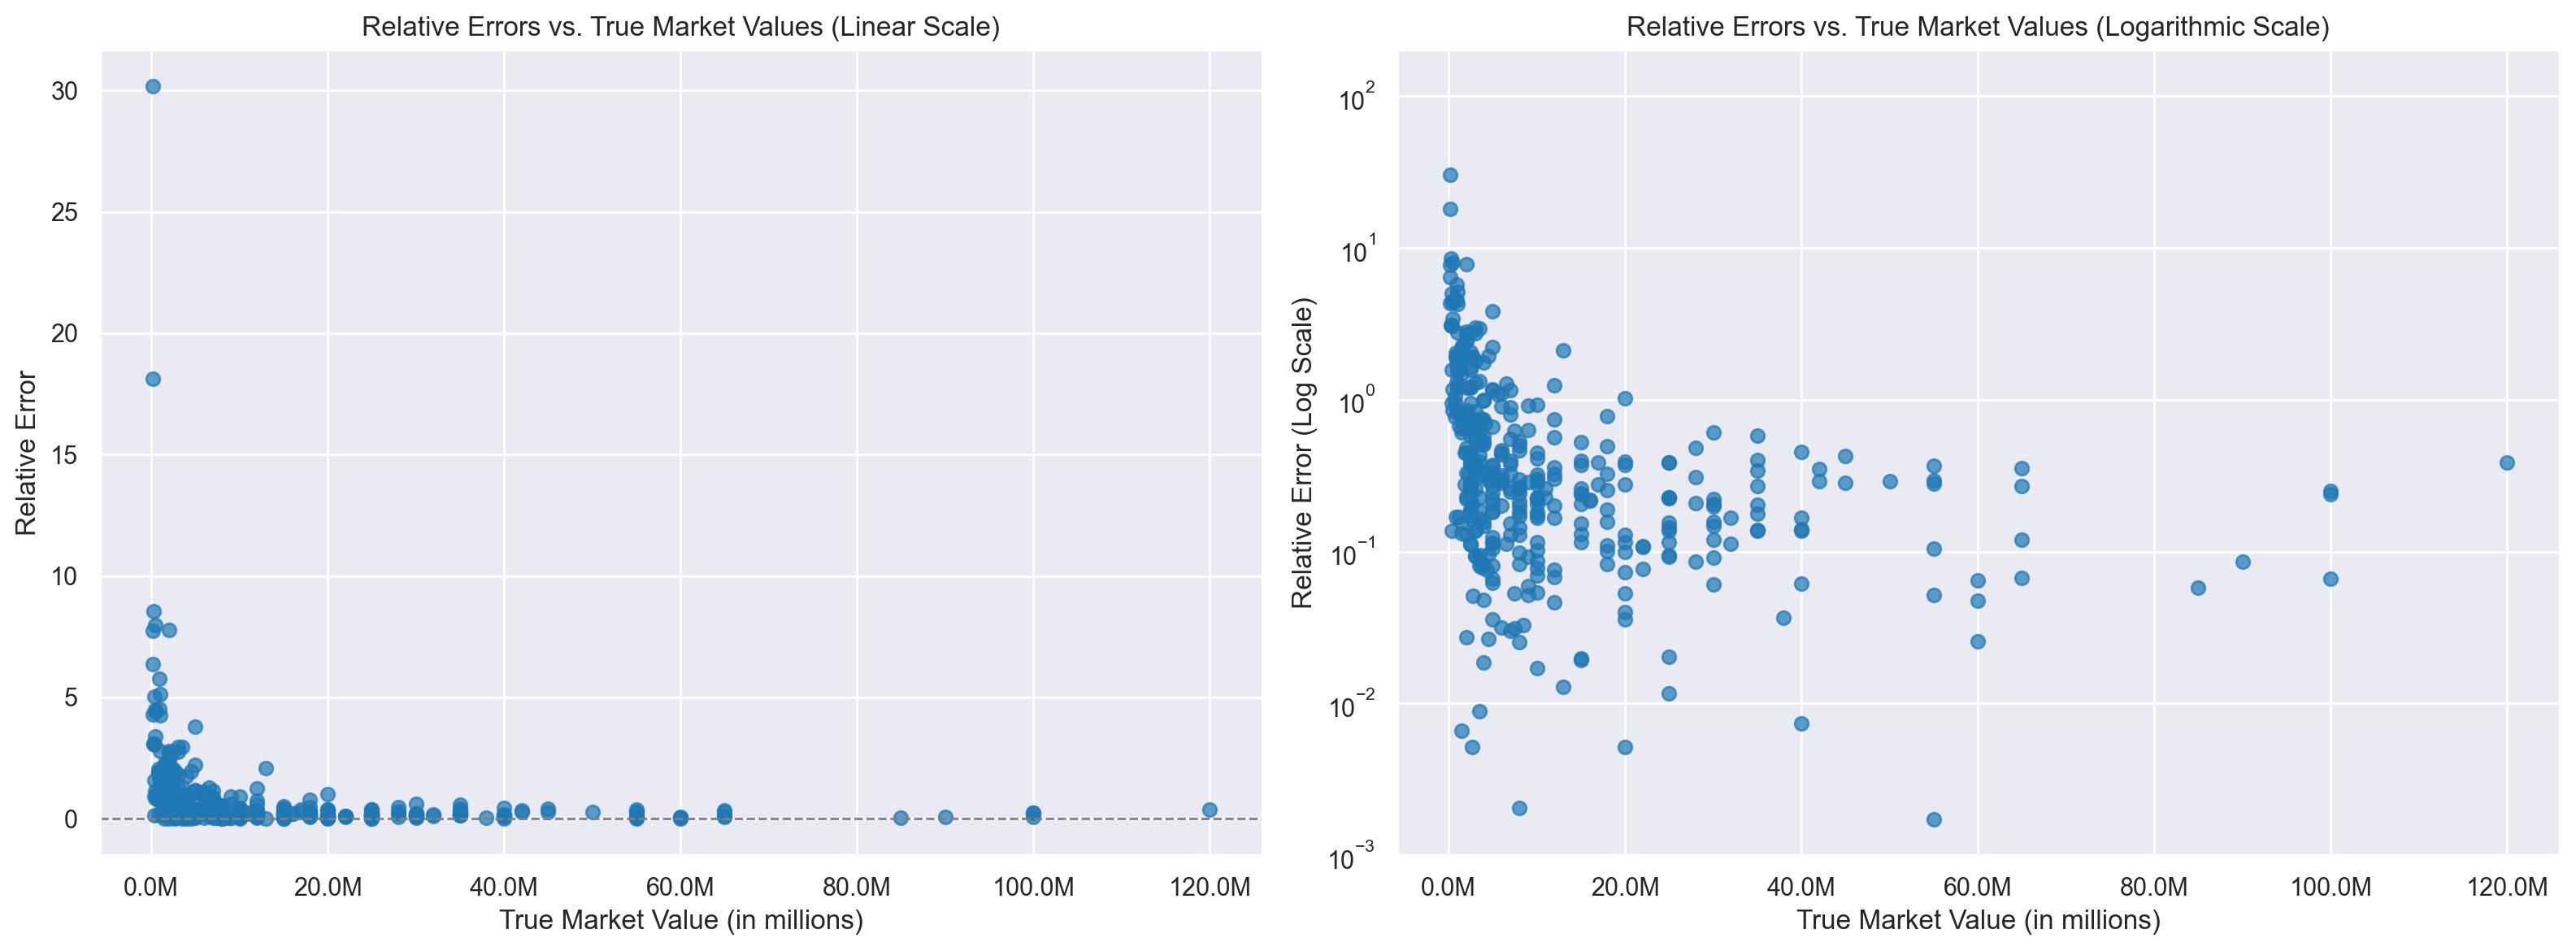

In [37]:
relative_errors = abs_errors / y_test

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Without logarithmic scale
axes[0].scatter(y_test, relative_errors, alpha=0.7)
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[0].set_title('Relative Errors vs. True Market Values (Linear Scale)')
axes[0].set_xlabel('True Market Value (in millions)')
axes[0].set_ylabel('Relative Error')
axes[0].grid(True)
axes[0].xaxis.set_major_formatter(FuncFormatter(millions_formatter))

# With logarithmic scale
axes[1].scatter(y_test, relative_errors, alpha=0.7)
axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('Relative Errors vs. True Market Values (Logarithmic Scale)')
axes[1].set_xlabel('True Market Value (in millions)')
axes[1].set_ylabel('Relative Error (Log Scale)')
axes[1].set_yscale('log')
axes[1].set_ylim(10e-4, None) 
axes[1].grid(True)
axes[1].xaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.tight_layout()
plt.show()

From the first plot, we observe that for some players with very small market values close to zero, the relative error is high, indicating poor predictions for these cases. However, this is expected given the wide range of market values our model is designed to predict. For players with high market values, the model performs well, and the predictions are relatively more precise.

In the second plot, which uses a logarithmic scale to better visualize the relative errors, we see that for most players with small market values, the model achieves a relative error lower than one. This indicates good predictions for players in this range. However, as market values decrease further, we notice an increase in the relative error for some players. This behavior is expected due to the broad range of market values in the dataset, making predictions for very low market values more challenging.

# Conclusion:

In this project, we managed to create a dataset exploiting different ressources, perform cleaning and analysis on the features in order to explore the properties of the data. We managed to get a clean dataset to feed into our models. We identified the best model in terms of performance and we used it to predict on our test set. The results were satisfying and an analysis of the error gave us an idea about the performance of the model both on average and in specific cases. For future improvements, we could reduce the number of features to the most important ones according to our models in order to simplify the task, and include new types of featurs, and gather more data. For example, it would be interesting to add the number of trophies won by a player. This would help a lot in predicting market value because the player winning more titles tend to be more expensive, and probably this would allow to include outliers with market value over €125m without compromising much the stability of our models.